# Big Query Rai Data Acquisition and Analysis

In this notebook, we will query Rai system data from Google's Big Query and create the same datasets seen in (TheGraphDataSetCreation.ipynb)[TheGraphDataSetCreation.ipynb] with higher fidelity.


Access and libraries were was obtained by from the following tutorials:
* https://cloud.google.com/docs/authentication/getting-started#cloud-console
* https://cloud.google.com/bigquery/docs/pandas-gbq-migration


## Data Fields required (Data point: Big Query table)
* Total Supply
* Global Debt
* Redemption Price: OracleRelayer_event_UpdateRedemptionPrice
* Redemption Rate
* Debt ceiling
* Rai market price
* Total Collateral
* ETH Price (Next OSM): ChainlinkMedianETHUSD_event_UpdateResult
* Eth Price (OSM): OSM_event_UpdateResult
* System surplus
* Active safes
* Surplus
* Debt to settle
* Uniswap pool information


In [103]:
# import libraries
import os
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

%matplotlib inline

# constants
constant = 1000000000000000000

#defining creditionals
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aclarkdata/Downloads/raidata-5e1723d42cf5.json'

# initializing agent
client = bigquery.Client()


In [104]:
# SQL query
sql = """
SELECT * 
FROM `blockchain-etl.ethereum_rai.ChainlinkMedianETHUSD_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_next_OSM = client.query(sql).to_dataframe()

In [105]:
eth_price_next_OSM['ETH Price (Next OSM)'] = eth_price_next_OSM['medianPrice'].astype(float)/constant
del eth_price_next_OSM['medianPrice']

eth_price_next_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM)
0,2021-04-16 13:58:11+00:00,12251491,0xbb94d1b73dd4477f5c9d02610d6903ed676e1c1be8f4...,263,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618581491,2357.750000
1,2021-04-16 12:48:13+00:00,12251167,0x930056eb945f4e7ec6d7fc1813aa129938189ce7b1e0...,267,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618577293,2391.880000
2,2021-04-16 11:39:28+00:00,12250884,0x8da459ba9d33087d4fcc09561b1be288287b1071d4ee...,195,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618573168,2371.100000
3,2021-04-16 10:28:52+00:00,12250528,0x9e5f2a2a14a951ae20f83ea98b88ad20fd3af7d7255a...,217,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618568932,2403.440000
4,2021-04-16 09:18:06+00:00,12250199,0xd06dcc1601a732bfbdcd747f155042b265ed43ced6b8...,64,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618564686,2408.666527


In [106]:

# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OSM_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_OSM = client.query(sql).to_dataframe()
eth_price_OSM['ETH Price (OSM)'] = eth_price_OSM['newMedian'].astype(float)/constant
del eth_price_OSM['newMedian']

eth_price_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (OSM)
0,2021-04-16 14:10:06+00:00,12251532,0xf165d86c86b519707c415fccffb200a25cd3a7cb5f34...,263,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1618581600,2391.880000
1,2021-04-16 13:09:43+00:00,12251273,0x8f8b0a4cc1d65b9d92875b8c7e6eb639b08afd7d8d4f...,149,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1618578000,2371.100000
2,2021-04-16 12:09:42+00:00,12251016,0xc79e4eb44937a6411100351af1f9e0cbe9df174fa7c2...,84,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1618574400,2403.440000
3,2021-04-16 11:09:45+00:00,12250747,0x16cc840f7eac63eee46199a91fc3e52b64e0bf04f619...,91,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1618570800,2408.666527
4,2021-04-16 10:09:59+00:00,12250444,0xb8f157607c550284a4e46f46dc71f5d0469be283e3a1...,338,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1618567200,2429.936728


In [171]:
import json
import requests
url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

blocknumbers = eth_price_OSM.block_number.values.tolist()

state = []
for i in blocknumbers:
    query = '''
    {
      systemState(block: {number:%s},id:"current") { 
        coinUniswapPair {
          reserve0
          reserve1
        }
        currentCoinMedianizerUpdate{
          value
        }
        currentRedemptionRate {
          eightHourlyRate
          annualizedRate
          hourlyRate
          createdAt
        }
        currentRedemptionPrice {
          value
        }
        erc20CoinTotalSupply
        globalDebt
        globalDebtCeiling
        totalActiveSafeCount
        coinAddress
        wethAddress
        systemSurplus
        debtAvailableToSettle
        lastPeriodicUpdate
        createdAt
        createdAtBlock
      }
    }
    ''' % i
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['systemState']
    state.append(s)
        
systemState = pd.DataFrame(state)

systemState['block_number'] = blocknumbers


systemState.head()
    


,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
0,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '28255549.928970784491501484', 'r...",1529678381,5834717,{'value': '3.038557206630989882'},{'value': '3.015764247243655582791167866'},{'annualizedRate': '0.876006592381750831947006...,2103.518374295953903228734667282724,30705490.85336032758258793,30967540.00659185573181455059814463,115792089237316195423570985008687.9,1618579072,197413.0150397456697090277724964703,804,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12251532
1,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '28294534.931559137710871791', 'r...",1529678381,5834717,{'value': '3.05784964056641429'},{'value': '3.015855701291908366492214624'},{'annualizedRate': '0.876006592381750831947006...,2103.518374295953903228734667282724,30827737.231717267053190207,31089376.56422877402571262459814463,115792089237316195423570985008687.9,1618576655,197413.0150397456697090277724964703,807,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12251273
2,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '28202386.057045562858018124', 'r...",1529678381,5834717,{'value': '3.05784964056641429'},{'value': '3.015855701291908366492214624'},{'annualizedRate': '0.876006592381750831947006...,2103.518374295953903228734667282724,30845414.794750315364675358,31109316.01916067921360767302511837,115792089237316195423570985008687.9,1618573168,197295.0814225837861049753021318905,809,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12251016
3,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '29201737.560088164166420463', 'r...",1529678381,5834717,{'value': '3.05784964056641429'},{'value': '3.015918527390015358099497713'},{'annualizedRate': '0.810719390749607317963464...,2103.518374295953903228734667282724,31589531.254725727693862058,31850943.51536077468151848902511837,115792089237316195423570985008687.9,1618568932,197295.0814225837861049753021318905,812,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12250747
4,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '29290643.485810927750481846', 'r...",1529678381,5834717,{'value': '3.05784964056641429'},{'value': '3.015990489328253481179995763'},{'annualizedRate': '0.810719390749607317963464...,2103.518374295953903228734667282724,31615576.551615968342718156,31876901.69443550655383682802511837,115792089237316195423570985008687.9,1618564030,197295.0814225837861049753021318905,812,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12250444


In [172]:
systemState.tail()

,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
1441,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",1529678381,5834717,{'value': '0'},{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,1613394096,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861502
1442,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613387890,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861237
1443,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613384616,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861008
1444,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.522357955470745187436691184972,115792089237316195423570985008687.9,1613383785,0.06853325908830422221834559248594176,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11860755
1445,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,None,1529678381,5834717,None,None,None,0,0,0,0,1613219947,0,0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11848351


In [173]:
systemState.columns

Index(['coinAddress', 'coinUniswapPair', 'createdAt', 'createdAtBlock',
       'currentCoinMedianizerUpdate', 'currentRedemptionPrice',
       'currentRedemptionRate', 'debtAvailableToSettle',
       'erc20CoinTotalSupply', 'globalDebt', 'globalDebtCeiling',
       'lastPeriodicUpdate', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'block_number'],
      dtype='object')

In [174]:
systemState.drop(systemState.tail(1).index,inplace=True) # drop last row

systemState['coinUniswapPair'].tail()

1440    {'reserve0': '801.933726709008306816', 'reserv...
1441    {'reserve0': '801.933726709008306816', 'reserv...
1442    {'reserve0': '676.933726709008306816', 'reserv...
1443    {'reserve0': '676.933726709008306816', 'reserv...
1444    {'reserve0': '676.933726709008306816', 'reserv...
Name: coinUniswapPair, dtype: object

In [175]:
systemState['RedemptionRateAnnualizedRate'] = systemState.currentRedemptionRate.apply(lambda x: x['annualizedRate'])
systemState['RedemptionRateHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['hourlyRate'])
systemState['RedemptionRateEightHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['eightHourlyRate'])
systemState['RedemptionPrice'] = systemState.currentRedemptionPrice.apply(lambda x: x['value'])
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])
del systemState['currentRedemptionRate']
del systemState['currentRedemptionPrice']
systemState['RedemptionRateAnnualizedRate'] = systemState['RedemptionRateAnnualizedRate'].astype(float)
systemState['RedemptionRateHourlyRate'] = systemState['RedemptionRateHourlyRate'].astype(float)
systemState['RedemptionRateEightHourlyRate'] = systemState['RedemptionRateEightHourlyRate'].astype(float)
systemState['RedemptionPrice'] = systemState['RedemptionPrice'].astype(float)
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState['RAIInUniswapV2(RAI/ETH)'].astype(float)



In [176]:
len(systemState)

1445

In [177]:
len(eth_price_OSM)

1446

In [178]:
systemState['timestampDiff'] = systemState['createdAt'].astype(float).diff() * -1
systemState['timestampDiff'] = systemState['timestampDiff'][1:-2]
systemState['timestampDiff'].describe()

count    1442.0
mean        0.0
std         0.0
min        -0.0
25%        -0.0
50%        -0.0
75%        -0.0
max        -0.0
Name: timestampDiff, dtype: float64

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


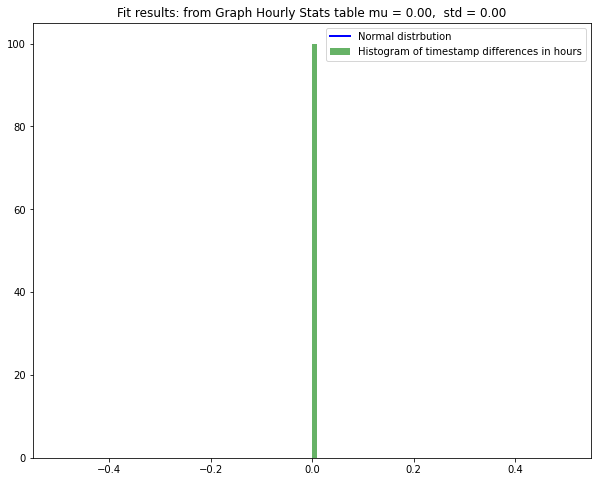

In [179]:
# convert to hours
data = systemState.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

## Time Analysis

In [107]:
eth_price_OSM['timestampDiff'] = eth_price_OSM['lastUpdateTime'].astype(float).diff() * -1
eth_price_OSM['timestampDiff'] = eth_price_OSM['timestampDiff'][1:-2]
eth_price_OSM['timestampDiff'].describe()

count    1443.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: timestampDiff, dtype: float64

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


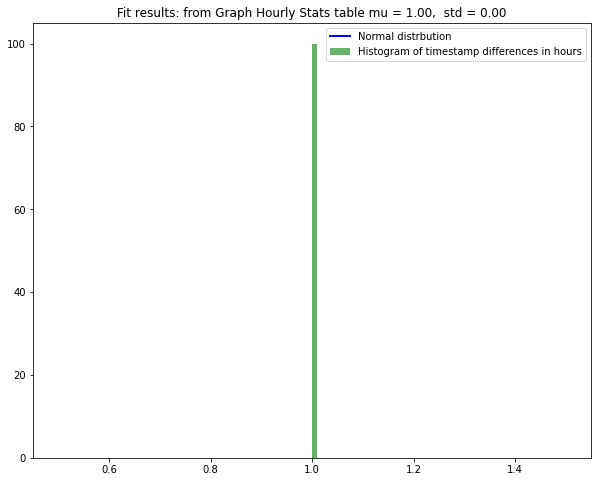

In [170]:
# convert to hours
data = eth_price_OSM.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

In [143]:
subset_eth = eth_price_OSM[['ETH Price (OSM)','block_number']]

In [139]:
master = eth_price_next_OSM.merge(systemState,how='inner',on='block_number')
master = master.merge(subset_eth,how='inner',on='block_number')

In [146]:
master.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM),coinAddress,coinUniswapPair,currentCoinMedianizerUpdate,...,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),ETH Price (OSM)
0,2021-04-05 23:09:57+00:00,12182570,0x97d4f653d6913c9cc85b5498df332e895ef6d079b2c3...,282,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617664197,2104.170974,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31041801.125122501466135463', 'r...",{'value': '3.089552584272848259'},...,115792089237316195423570985008687.9,187338.5959485606686820321694960594,984,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.893578,0.999987,0.999897,3.030509,3.104180e+07,2117.650000
1,2021-04-02 20:09:56+00:00,12162180,0x54b61efbebaadaf3cc7df50be548ec642d427c78a566...,231,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617394196,2072.713775,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '32035699.997107805187441075', 'r...",{'value': '3.087059599504075646'},...,115792089237316195423570985008687.9,184264.3263143241582880245129434617,981,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.846295,0.999981,0.999848,3.033423,3.203570e+07,2052.464741
2,2021-04-02 07:13:07+00:00,12158673,0xd1a62352415d08be52cd4cebfefd7811bb0f3c5093da...,259,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617347587,1998.000000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31509283.060081752223705783', 'r...",{'value': '3.063290021701211213'},...,115792089237316195423570985008687.9,183712.5657625425875127865653801174,983,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.911912,0.999989,0.999916,3.034000,3.150928e+07,1991.766574
3,2021-03-29 12:09:57+00:00,12134065,0x7fa7fb984f80e92dcf64f523fb5ceac5c55cc331ffc5...,364,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617019797,1777.289555,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '36225653.949187886673282187', 'r...",{'value': '3.007335860269551736'},...,115792089237316195423570985008687.9,179640.3035482553016037784209888087,999,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.242260,1.000025,1.000198,3.033300,3.622565e+07,1767.251649
4,2021-03-25 20:09:47+00:00,12110194,0x3259bdf3aad1248337c27b9cba2ff9fb5127a89a0d6d...,41,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1616702987,1607.400000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '34427813.290379045822885935', 'r...",{'value': '2.944074679257019725'},...,115792089237316195423570985008687.9,175617.172673347380380196043242654,993,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.395665,1.000038,1.000304,3.027886,3.442781e+07,1602.851185


In [148]:
master.to_csv('testing.csv')

## Additional

In [109]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OracleRelayer_event_UpdateRedemptionPrice`
ORDER By block_timestamp DESC

"""

redemptionPrice = client.query(sql).to_dataframe()

redemptionPrice['RAI Redemption Price'] = redemptionPrice['redemptionPrice'].astype(float)/constant
del redemptionPrice['redemptionPrice']
redemptionPrice.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,RAI Redemption Price
0,2021-04-16 14:10:06+00:00,12251532,0xc2fae791be1507b450301640aac1c05de181705cc301...,264,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.015764e+09
1,2021-04-16 13:09:45+00:00,12251274,0x93939b0a7d6d46316eacee0803f037dae5d7674eb58b...,226,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.015810e+09
2,2021-04-16 12:09:42+00:00,12251016,0x2bfb83ae2614429e0375d8144010de28bdbc92e2b1a2...,85,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.015856e+09
3,2021-04-16 11:48:39+00:00,12250929,0xb27f15f9ed528221e9bd9b561d071bfe63fdedc561ef...,190,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.015872e+09
4,2021-04-16 11:09:45+00:00,12250747,0x3fc8d4c0f916e3bebeb44062afe990dcb5b02fc43070...,138,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.015919e+09


In [137]:
redemptionPrice['RAI Redemption Price']

0       3.015764e+09
1       3.015810e+09
2       3.015856e+09
3       3.015872e+09
4       3.015919e+09
            ...     
1923    3.140000e+09
1924    3.140000e+09
1925    3.140000e+09
1926    3.140000e+09
1927    3.140000e+09
Name: RAI Redemption Price, Length: 1928, dtype: float64

In [136]:
systemState['RedemptionPrice']

0       3.015764
1       3.015856
2       3.015856
3       3.015919
4       3.015990
          ...   
1440    3.140000
1441    3.140000
1442    3.140000
1443    3.140000
1444    3.140000
Name: RedemptionPrice, Length: 1445, dtype: float64